In [1]:
# Make the ouput directory
!mkdir temporary_data

mkdir: cannot create directory ‘temporary_data’: File exists


In [2]:
# Input files for this script
code_list_file = 'data/example_codebook_design/HM4_codes_22.json'
cluster_gene_exp_file = 'data/example_codebook_design/cluster_gene_exp.npz'
cluster_sizes_file = 'data/example_codebook_design/cluster_sizes.npz'
genes_Zhang_file = 'data/example_codebook_design/genes_Zhang_MOp.csv'
# The output file
codebook_file = 'temporary_data/codebook.txt'

In [3]:
# Load the modules
import json
import numpy as np
import pandas as pd
from MERFISH_probe_design.hamming_codes import code_selection, hamming_code_analysis
import MERFISH_probe_design.codebook_design.codebook_design_stochastic as cds
import MERFISH_probe_design.IO.file_io as fio

In [4]:
# Load a list of HM4 codes
with open(code_list_file, 'r') as f:
    code_list = json.load(f)
print(f'Loaded {len(code_list)} HM4 codes.')
    
code_length = 22

Loaded 298 HM4 codes.


In [5]:
# Selec a subset of codes that evenly cover the bits
# Select the codes for genes
N_genes = 242
gene_codes, rest_codes = code_selection.find_subset_code_even_coverage(code_list, code_length, N_genes, N_rounds=20)

# Select blank barcodes randomly
N_blank = 10
np.random.shuffle(rest_codes)
blank_codes = rest_codes[:N_blank]

Round = 1, variance = 0.09090909090909091
Round = 2, variance = 0.18181818181818182
Round = 3, variance = 0.18181818181818182
Round = 4, variance = 0.18181818181818182
Round = 5, variance = 0.09090909090909091
Round = 6, variance = 0.18181818181818182
Round = 7, variance = 0.09090909090909091
Round = 8, variance = 0.09090909090909091
Round = 9, variance = 0.18181818181818182
Round = 10, variance = 0.09090909090909091
Round = 11, variance = 0.09090909090909091
Round = 12, variance = 0.18181818181818182
Round = 13, variance = 0.18181818181818182
Round = 14, variance = 0.2727272727272727
Round = 15, variance = 0.18181818181818182
Round = 16, variance = 0.18181818181818182
Round = 17, variance = 0.18181818181818182
Round = 18, variance = 0.18181818181818182
Round = 19, variance = 0.18181818181818182
Round = 20, variance = 0.09090909090909091


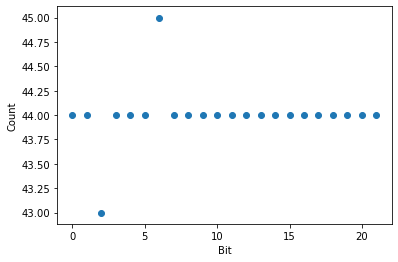

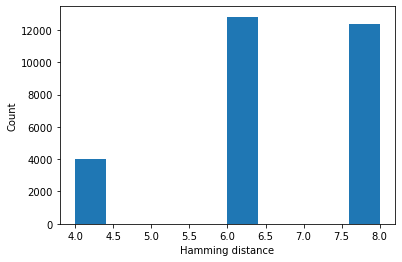

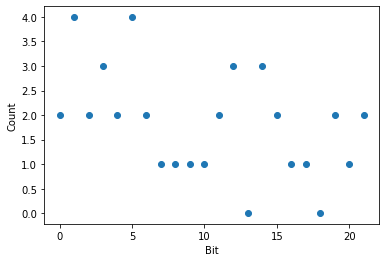

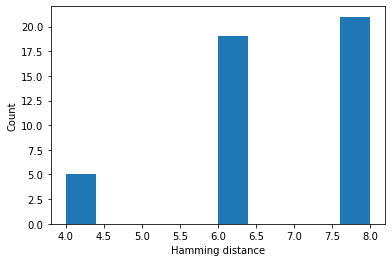

In [6]:
# Plot distributions of gene codes
hamming_code_analysis.plot_bit_coverage(gene_codes, code_length)
hamming_code_analysis.plot_pairwise_hamming_distance_distribution(gene_codes)
# Plot distributions of blank codes
hamming_code_analysis.plot_bit_coverage(blank_codes, code_length)
hamming_code_analysis.plot_pairwise_hamming_distance_distribution(blank_codes)

In [7]:
# Load the gene expressions for each cell cluster.
# This is a matrix of shape N_clusters x N_genes_of_interest.
# Each element is the expression level of a gene in a cluster.
cluster_gene_exp = np.load(cluster_gene_exp_file)['arr_0']

# Normalize the expressions, such that the sum of all expressions are N_clusters.
# The normalization is important for the subsequent simulated annealing.
cluster_gene_exp_normalized = cluster_gene_exp / np.sum(cluster_gene_exp) * cluster_gene_exp.shape[0]

In [8]:
# Load the cluster sizes
cluster_sizes = np.load(cluster_sizes_file)['arr_0']
# Log normalize the cluster sizes
cluster_sizes_log_normalized = np.log(cluster_sizes + 1) / np.sum(np.log(cluster_sizes + 1))

In [10]:
# Convert the gene codes to binary codes
gene_binary_codes = np.array([cds.on_bits_to_binary_code(c, code_length) for c in gene_codes])

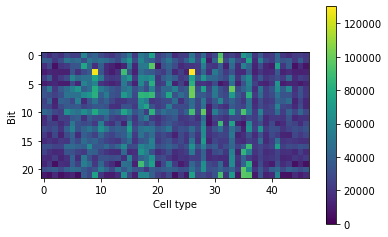

In [11]:
# Plot the distribution of numbers of bright dots in cells before optimization
# The values have the unit dot per million transcripts
cds.plot_dot_distribution(cluster_gene_exp, gene_binary_codes)

In [12]:
from importlib import reload
reload(cds)
# Optimize the code assigment to let cells have evenly distributed dots for each bit
# Use the log of cluster sizes to weight the divergence which we want to minimize
best_score, best_codes = cds.optimize_bit_assignments_simulated_annealing_parallel(
    cluster_gene_exp_normalized, cluster_sizes_log_normalized, gene_binary_codes,
    N_test=64, N_threads=16, N_rounds=5, N_iter=20000)

Simulated annealing finished with best score = 0.0010386654865624022.
Simulated annealing finished with best score = 0.0009370331890250586.
Simulated annealing finished with best score = 0.0010085304508496728.
Simulated annealing finished with best score = 0.0009733328121883403.
Simulated annealing finished with best score = 0.0010008352489088703.
Simulated annealing finished with best score = 0.0010007206230404576.
Simulated annealing finished with best score = 0.000961989832261459.
Simulated annealing finished with best score = 0.001027458234486937.
Simulated annealing finished with best score = 0.0010083610644077787.
Simulated annealing finished with best score = 0.0010387402651789038.
Simulated annealing finished with best score = 0.0010300369900385585.
Simulated annealing finished with best score = 0.0009961080159202461.
Simulated annealing finished with best score = 0.0010238652104118935.
Simulated annealing finished with best score = 0.0009618651372480555.
Simulated annealing fi

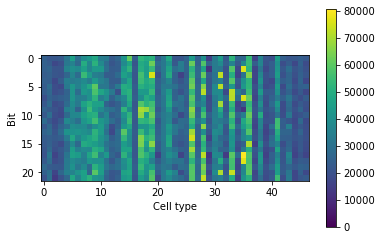

,cell_type_weights
0,0.027249
1,0.026989
2,0.025078
3,0.025003
4,0.024755
5,0.023679
6,0.023350
7,0.023345
8,0.022975
9,0.022949


In [13]:
# The dot distribution is better now.
# There are vertical strip patterns that our optimization didn't change. 
# This is because we can only optimize the distribution across bits.
# The total number of bright dots for each cell type is always 4 x N_expressed_transcripts.
cds.plot_dot_distribution(cluster_gene_exp, best_codes)

# Note that dots in some of the cell types with few cells are not very evenly distributed
pd.DataFrame({'cell_type_weights': cluster_sizes_log_normalized})

In [14]:
# Load the gene and transcript names
genes_Zhang = pd.read_csv(genes_Zhang_file)

In [15]:
# The names of MERFISH readout probes
bit_names = ["RS0015", "RS0083", "RS0095", "RS0109", "RS0175", "RS0237", "RS0247", "RS0255", "RS0307", "RS0332",
             "RS0343", "RS0384", "RS0406", "RS0451", "RS0468", "RS0548", "RS0578", "RS0584", "RS0639", "RS0707",
             "RS0708", "RS0730", "RS0763", "RS0793", "RS0805", "RS0820", "RS0896", "RS0967", "RS0994", "RS0996",
             "RS1040", "RS1047", "RS1199", "RS1261", "RS1312", "RS1316"]

In [16]:
# Get a list of gene names including the blank barcodes
gene_names = [f'Blank-{i + 1}' for i in range(N_blank)] + list(genes_Zhang['gene'])

# Get a list of transcript names including the blank barcodes
transcript_names = [f'' for i in range(N_blank)] + list(genes_Zhang['transcript'])

# Convert the barcodes into strings of '1' and '0'.
barcode_binarys = [cds.on_bits_to_binary_code(c, code_length) for c in blank_codes] + list(best_codes)
barcode_strings  = [''.join([str(b) for b in c]) for c in barcode_binarys]

# Write the codebook
fio.write_merlin_codebook(codebook_file, '1.0', 'TEST', bit_names, gene_names, transcript_names, barcode_strings)